<a href="https://colab.research.google.com/github/GDS-Education-Community-of-Practice/DSECOP/blob/main/Learning_the_Schrodinger_Equation/02_TD_Schrodinger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solving the Time Dependent Schrodinger Equation with Physics-Informed Deep Learning

In [1]:
import sys


In [2]:
print(sys.path)

['/Users/karan-casus/Research/DSECOP_fix_202211/Learning_the_Schrodinger_Equation', '/Users/karan-casus/miniforge3/envs/torch-nightly/lib/python38.zip', '/Users/karan-casus/miniforge3/envs/torch-nightly/lib/python3.8', '/Users/karan-casus/miniforge3/envs/torch-nightly/lib/python3.8/lib-dynload', '', '/Users/karan-casus/miniforge3/envs/torch-nightly/lib/python3.8/site-packages']


In [3]:

print(sys.path)

['/Users/karan-casus/Research/DSECOP_fix_202211/Learning_the_Schrodinger_Equation', '/Users/karan-casus/miniforge3/envs/torch-nightly/lib/python38.zip', '/Users/karan-casus/miniforge3/envs/torch-nightly/lib/python3.8', '/Users/karan-casus/miniforge3/envs/torch-nightly/lib/python3.8/lib-dynload', '', '/Users/karan-casus/miniforge3/envs/torch-nightly/lib/python3.8/site-packages']


In [4]:
import numpy as np
import sys

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.image as img
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from ipywidgets import interact
import ipywidgets as widgets

sys.path.insert(1, './res')
from ml_helper import *

torch.set_default_tensor_type(torch.DoubleTensor)

## Time Dependent Quantum Harmonic Oscillator

In this notebook, we want to solve a Quantum Harmonic Oscillator consisting of a superposition of two states.
Note: We will use atomic units unless specified: $\hbar=m=e=1$. 


The governing equation is time-dependent Schrödinger equation
\begin{equation}
i \frac{\partial \psi(\mathbf{r}, t)}{\partial t}-\hat{H} \psi(\mathbf{r}, t)=0
\end{equation} 
for a quantum harmonic oscillator consisting of the superposition of two eigenstates $m,n$. In the one-dimensional case, the Hamiltonian is
\begin{equation}
\hat{H_x}=-\frac{1}{2}\frac{\partial^{2}}{\partial x^{2}}+\frac{\omega^{2}}{2}x^{2}
\end{equation}
The analytical solution $\psi(x,t) \in \mathbb{C}$ is
\begin{equation*}
\phi_0(x) = \sqrt[4]{\frac{\omega}{\pi}}e^{\left(-\frac{\omega x^2}{2}\right)}
\end{equation*}
\begin{equation*}
\phi_1(x) = \phi_0(x) \sqrt{2\omega}x
\end{equation*}
For higher states,
\begin{equation*}
\phi_n(x) = \phi_0(x) \frac{1}{\sqrt{2^n n!}}Her_n(\sqrt{\omega}x)\exp\left(-i E_n t\right)
\end{equation*}
where $Her_n(\sqrt{\omega}x)$ is the $n$th Hermite polynomial,
and phase $\exp\left(-i E_n t\right)$ where $E_n = (n+\frac{1}{2})\omega$

The superposition is defined as
\begin{equation}
\psi_{m,n}(x,t) = \frac{1}{\sqrt{2}}\left( e^{\left(-i E_m t\right)}\phi_m(x) + e^{\left(-i E_n t\right)}\phi_n(x)\right)
\end{equation}

## Base case: $\psi_{0,1}(x,t)$

Let's derive the analytical solution for $\psi_{0,1}(x,t)$.

\begin{equation}
\psi_{0,1}(x,t) = \frac{1}{\sqrt{2}}\left( e^{\left(-i E_0 t\right)}\phi_m(x) + e^{\left(-i E_1 t\right)}\phi_n(x)\right)
\end{equation}

The $nth$ Physicist's Hermite Polynomial is defined as:
$$H_{n}(y)=(-1)^{n} e^{y^{2}} \frac{d^{n}}{d y^{n}} e^{-y^{2}}$$

---
Exercise: 

a) Derive the first Hermite Polynomial ($H_{1}(y)$) in terms of $x$ for $y=\sqrt{\omega}x$:

Derivation here
$H_{1}(\sqrt{\omega}x) = $

b) Write down the ground state and first excited state energies for QHO:

$E_0 =$,
$E_1=$

c) Use your results from $a$ and $b$ to write down $\psi_{0,1}(x,t)$, and simplify it:

$\psi_{0,1}(x,t) = $


---

Now that we have our analytical solution, let's write some code to compute it for arbitrary values of $x,t,\omega$

In [5]:
def get_analytical_solution_base(X,T,omega):
    # Analytical solution for first two states. X,T are numpy arrays, omega is a float.
    # Hint: Avoid using for loops, use numpy functions to calculate the wavefunction.
    
    #Solution:
    phi_0 = (omega / np.pi) ** (1. / 4.) * np.exp(-X * omega * X / 2.0)
    phi_1 = phi_0 *  np.sqrt(omega / 2.) * 2.0 * X
    psi = np.sqrt(1. / 2.) * (np.exp(-1j * omega/2 * T) * phi_0 + np.exp(-1j* 3/2 * omega * T) * phi_1)

    return psi

Let's define the domain for our problem:

We will restrict our domain to $\mathbf{x} \in [-\pi,\pi], t \in [0,T]$, with fixed boundary conditions $x_0, x_b = 0$ in this notebook. 

After you go through the notebook, feel free to play with the code for other domains. Let's create some data using the function you just wrote.

In [6]:
def get_data_set(x_dom, t_dom, delta_X, delta_T, omega, analytical_solution_fun):
    # Helper function to generate datasets from analytical solutions.
    

    x = np.arange(x_dom[0], x_dom[1], delta_X).astype(float)
    t = np.arange(t_dom[0], t_dom[1], delta_T).astype(float)
    X, T = np.meshgrid(x, t)

    X = np.expand_dims(X.flatten(), axis=-1)
    T = np.expand_dims(T.flatten(), axis=-1)

    psi_val = analytical_solution_fun(X,T,omega)
    u = np.real(psi_val)
    v = np.imag(psi_val)

    train_input = np.hstack((X,T))
    train_output = np.hstack((u,v))

    train_x = torch.tensor(train_input)
    train_y = torch.tensor(train_output)

    return train_x, train_y

In [7]:
# Define domain in code

L = float(np.pi)
omega = 1
delta_T = 0.01
delta_X = 0.01
x_dom = [-L,L]
t_dom = [0, 2*L]
analytical_solution_function = get_analytical_solution_base

test_x, test_y = get_data_set(x_dom, t_dom, delta_X, delta_T, omega, analytical_solution_function)

Here `delta_T` and `delta_X` are the grid spacing in our domain. Data will be generated on this grid. You cna move the slider to see how the probabilty density of the QHO evolves in time. Our system looks like this:


In [8]:
@interact(t=widgets.IntSlider(min=0, max=62, step=1, value=0))
def interactive_viz_colour(t):
    tstr = str(t).zfill(2)
    fname = f"res/plots/waveform/psi_0_1/t_{tstr}.png"
    image = img.imread(fname)
    plt.figure(figsize=(8,6))
    plt.axis('off')
    plt.imshow(image)
    plt.show()

interactive(children=(IntSlider(value=0, description='t', max=62), Output()), _dom_classes=('widget-interact',…

Now that we have the analytical solution, let's build a neural network to solve it. 

We will be using Mean Squared Error to quantify the difference between the true value and predicted values.
It is defined as 
$$ \mathrm{MSE}=\frac{1}{n} \sum_{i=1}^{n}\left(Y_{i}-\hat{Y}_{i}\right)^{2}$$
where $Y_i$ and $\hat{Y_i}$ are the $i$th predicted and true values respectively. Implement this in code below:

In [9]:
# Exercise: Implement mse function here
def get_mse(y_true, y_pred):
    
    # Solution:
    mse = np.mean((y_true - y_pred)**2)
    return mse

### Fully Connected Neural Network

A neural network consists of chained linear regression nodes (perceptrons) and activation functions. The first layer is called the input layer, the layers in the middele are called output layers and the final layer is called the output layer. A neural network surves as a function approximator between the input and the ouput.

![Domains](res/fig/nn_architecture.png)



Since neural networks are constrained to $\mathbb{R}$, the complex valued solution can be represented as 
\begin{equation}
\psi(x,t) = u + iv    
\end{equation} where $u = \operatorname{Re}(\psi)$ and $v=\operatorname{Im}(\psi)$

---

Exercise: What our input and output variable for this neural network?

Solution: Inputs: $x,t$, Outputs: $u,v$

---

Exercise: Write the Schrodinger equation in terms of $u$ and $v$

Solution:
The time-dependent Schrödinger equation can be written as
\begin{equation}
    \left(-\frac{\partial v}{\partial t}+\frac{1}{2}\frac{\partial^{2} u}{\partial x^{2}}-\frac{\omega^{2}}{2}x^{2}\right)\psi + i \left(\frac{\partial u}{\partial t}+\frac{1}{2}\frac{\partial^{2} v}{\partial x^{2}}-\frac{\omega^{2}}{2}x^{2}\right)\psi = 0
\end{equation}

---




In the first case, the training data is generated on a high resolution grid from the analytical solution described above. 
The neural network $\psi_{net}: \mathbb{R}^{1+1}\mapsto \mathbb{R}^{2}$ is constructed, with inputs $(x,t)$ and outputs $(u,v)$.


Let's look at the pipeline for creating, training and testing Neural Networks. Generate training and test data:

Note: In this case, we are using the entire dataset in training for demonstrating the workflow. This is not done in practice and leads to overfitting. 

In [10]:
L = float(np.pi)
omega = 1

# Grid spacing
delta_T = 0.1
delta_X = 0.1
# Domains
x_dom = [-L,L]
t_dom = [0, 2*L]

train_x, train_y = get_data_set(x_dom, t_dom, delta_X, delta_T, omega, get_analytical_solution_base)
test_x, test_y = get_data_set(x_dom, t_dom, delta_X, delta_T, omega, get_analytical_solution_base)

Create the architecture of Neural Network. This is a fully connected neural network (FCN):

In [11]:
class NN(nn.Module):
    
    def __init__(self, n_in, n_out, n_h, n_l, activation):
        super().__init__()

        
        self.f_in = nn.Linear(n_in, n_h)
        
        layers = []
        for l in range(n_l - 1):
            layers.append(nn.Linear(n_h, n_h))
            layers.append(activation)

        self.f_h = nn.Sequential(*layers)

        self.f_out = nn.Linear(n_h, n_out)
        
    def forward(self, x):
        x = self.f_in(x)
        x = activation(x)

        x = self.f_h(x)
        x = self.f_out(x)
        return x

Create a function to train the network:

In [12]:
def train_nn(model, n_epochs, train_x, train_y):
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

    loss_list = np.zeros(n_epochs)
    print("Epoch \t Loss")
    for i in range(n_epochs):
        optimizer.zero_grad()
        pred_y = model(train_x)

        loss = torch.mean((train_y-pred_y)**2)
        
        loss_list[i] = loss.detach().numpy()

        loss.backward()
        optimizer.step()

        if i % 500 == 499:
            print(f"{i} {loss}")
            
    return model, loss_list

Create a function to quantify the loss and errors

In [13]:
def get_model_error(model, test_x, test_y):
    model.eval()
    with torch.no_grad():

        pred_y = model(test_x)
        
        pred_u, pred_v, pred_dens = get_density(pred_y)
        test_u, test_v, test_dens = get_density(test_y)
        
        loss_u = torch.mean((pred_u - test_u)**2)
        loss_v = torch.mean((pred_v - test_v)**2)
        loss_dens = torch.mean((pred_dens - test_dens)**2)

        print(f"Model loss: \n {loss_u=} \n {loss_v=} \n {loss_dens=}")
        
    return pred_y

Function for inference and plotting

In [14]:
def inference(model, test_x, test_y,n_x, n_t, x_dom, t_dom, omega,plot_name="plot"):
    
    model.eval()
    with torch.no_grad():

        pred_y = model(test_x)
        
        pred_u, pred_v, pred_dens = get_density(pred_y)
        test_u, test_v, test_dens = get_density(test_y)

        loss_u = torch.mean((pred_u - test_u)**2)
        loss_v = torch.mean((pred_v - test_v)**2)
        loss_dens = torch.mean((pred_dens - test_dens)**2)
         
        # print(loss_u)
        # print(loss_v)
            
        get_plots_norm_colorbar(test_y,pred_y, n_x, n_t, x_dom, t_dom, plot_name)
        # return pred_y

Now that we have all the pieces in place, we can use this code to train a neural network on our domain.

In [15]:
torch.manual_seed(314)
activation =  nn.Tanh()

model_nn = NN(2,2,20,3,activation)
n_epochs = 10000


In [16]:
%%time
model_nn, loss_list = train_nn(model_nn, n_epochs, train_x, train_y)

Epoch 	 Loss
499 0.021311576302682503
999 0.006446792581396611
1499 0.0026024699297287745
1999 0.0014585544538422183
2499 0.000969064143342387
2999 0.0006720357392385875
3499 0.0004991817956217997
3999 0.00040307594214147597
4499 0.0003414361742182694
4999 0.0002980966958790387
5499 0.0002624531615338304
5999 0.0002337880071724617
6499 0.00020930188179294512
6999 0.0001862674678340401
7499 0.0001671911638799208
7999 0.00015094360233396388
8499 0.00019159192163465454
8999 0.00012615565532042518
9499 0.00011596528694147982
9999 0.00010794821564355785
CPU times: user 28 s, sys: 9.87 s, total: 37.9 s
Wall time: 20.8 s


The losses for different terms are:

In [17]:
pred_y = get_model_error(model_nn, test_x, test_y)

Model loss: 
 loss_u=tensor(0.0001) 
 loss_v=tensor(0.0001) 
 loss_dens=tensor(8.4007e-05)


And we can plot our reults with the inference function

0 finished
1 finished
2 finished


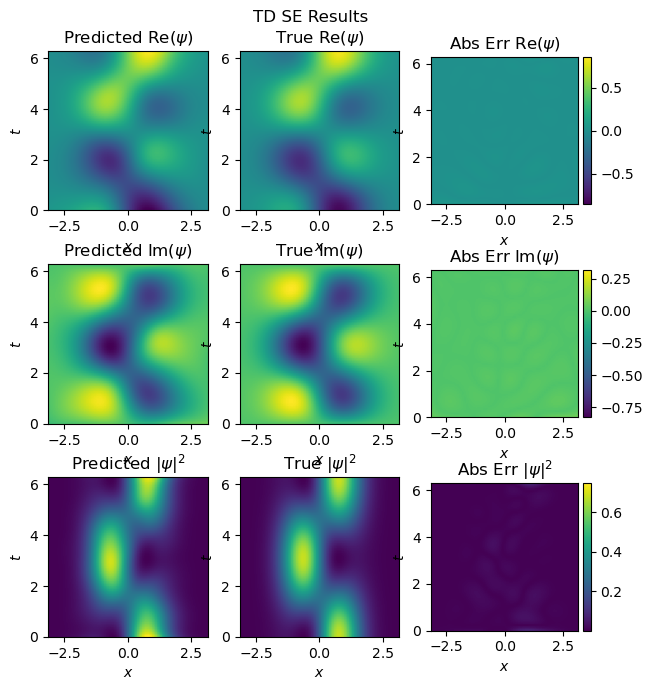

mse: u: 0.00010802502033025184, v:0.00010783958831362046


In [18]:
L = float(np.pi)
omega = 1
delta_T = 0.1
delta_X = 0.1
    
n_x = np.shape(np.arange(x_dom[0], x_dom[1], delta_X))[0]
n_t = np.shape(np.arange(t_dom[0], t_dom[1], delta_T))[0]

inference(model_nn, test_x, test_y, n_x, n_t, x_dom, t_dom, omega, 'nn')

Reading these snapshot plots: 
The first column consists of plots of neural network predictions The second column consists of true values and the last column is the Absolute Error between ground truth and predictions.

The rows are real($\psi$), imaginary($\psi$) and density $|\psi|^2$ .

In this case, since we used all the data over the domain for training, we get great results, where the NN approximates $\psi$ very well.

Now for a more realistic case. We might not have a lot of experimental data covering the entire domain of a system. To approximate that, let's train a neural network on a low resolution grid in a reduced domain $x \in [-\pi/4,\pi/4]$.

In [19]:
# Generate reduced training set
L = float(np.pi)
omega = 1

delta_T = 0.1
delta_X = 0.1
x_dom = [-L/4,L/4]
t_dom = [0, 2*L]

train_x, train_y = get_data_set(x_dom, t_dom, delta_X, delta_T, omega, get_analytical_solution_base)

We will test it's performance on a high resolution grid across the entire domain

In [20]:
delta_T = 0.01
delta_X = 0.01
x_dom = [-L,L]
t_dom = [0, 2*L]

test_x, test_y = get_data_set(x_dom, t_dom, delta_X, delta_T, omega, get_analytical_solution_base)

In [21]:

torch.manual_seed(314)
activation =  nn.Tanh()

model_nn = NN(2,2,20,3,activation)
n_epochs = 10000

    

In [22]:
%%time
model_nn, loss_list = train_nn(model_nn, n_epochs, train_x, train_y,)

Epoch 	 Loss
499 0.0280495968496817
999 0.009683315432743004
1499 0.0021036808695757167
1999 0.0010595504510319393
2499 0.0006268835876571616
2999 0.00043707036546786383
3499 0.00038426842386732573
3999 0.0002752534033127015
4499 0.0002220350165387498
4999 0.0002103187314452682
5499 0.00015301378664819997
5999 0.00012867610872426875
6499 0.00012275121374899606
6999 9.078175722118609e-05
7499 8.317079442034666e-05
7999 7.867830254489961e-05
8499 6.17620942632034e-05
8999 5.473440160811332e-05
9499 0.0003144758218846969
9999 4.519185228334742e-05
CPU times: user 9.81 s, sys: 4.7 s, total: 14.5 s
Wall time: 9.13 s


So far so good, the training loss is small. But across the entire domain, the loss is:

In [23]:
y_pred = get_model_error(model_nn, test_x, test_y)

Model loss: 
 loss_u=tensor(0.2763) 
 loss_v=tensor(0.5144) 
 loss_dens=tensor(4.0325)


The error is orders of magnitude higher than our data point values! Let's look at the plots:


0 finished
1 finished
2 finished


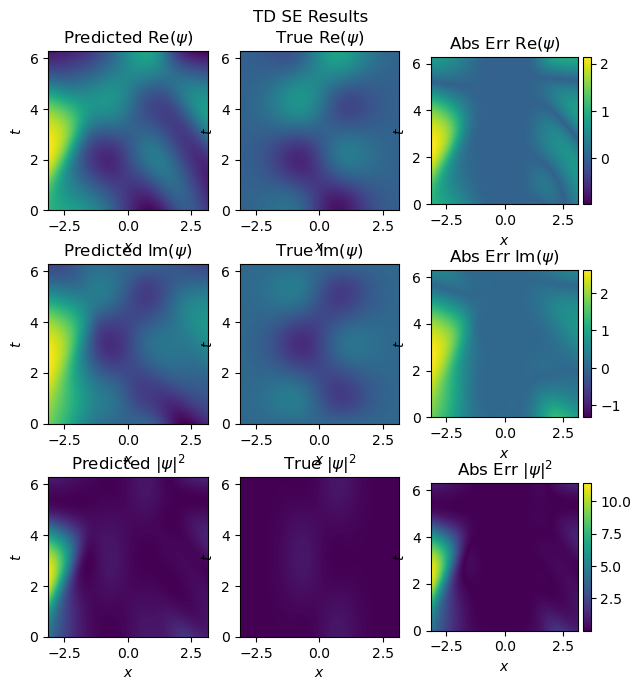

mse: u: 0.2763425748885986, v:0.5143525370130754


In [24]:
L = float(np.pi)
omega = 1
delta_T = 0.01
delta_X = 0.01
    
n_x = np.shape(np.arange(x_dom[0], x_dom[1], delta_X))[0]
n_t = np.shape(np.arange(t_dom[0], t_dom[1], delta_T))[0]

inference(model_nn, test_x, test_y, n_x, n_t, x_dom, t_dom, omega, 'nn_reduced')

The values are similar in the domain that we trained on $x \in [-0.78,0.78]$ but diverge considerably near the boundaries.

To tackle this problem, we will add some information about the governing equation in the neural network.

### Physics-Informed Neural Network

Physics Informed Neural Networks are constructed by encoding the constraints posed by a given differential equation and its boundary conditions into the loss function of a Fully Connected Network. This constraint guides the network to approximate the solution of the differential equation.

For a system $ f $, with solution $ u(\mathbf{x},t) $, governed by the following equation

\begin{align}\label{eq:pde}
f(u) &:=u_{t}+\mathcal{N}[u;\lambda], \mathbf{x} \in \Omega, t \in [0,T] \\
f(u) &= 0
\end{align} 
where $\mathcal{N}[u;\lambda]$ is a differential operator parameterised by $ \lambda $, $ \Omega \in \mathbb{R^D} $, $ \mathbf{x} = (x_1,x_2,...,x_d) $ with boundary conditions 
 \begin{equation}
\mathcal{B}(u, \mathbf{x},t)=0 \quad \text { on } \quad \partial \Omega
\end{equation}
 and initial conditions
 \begin{equation}
\mathcal{T}(u, \mathbf{x},t)=0 \quad \text { at } \quad t = 0
\end{equation}


![PINN architecture](res/fig/PINN_diagrams.png)

A neural network $u_{net}: \mathbb{R}^{D+1}\mapsto \mathbb{R}^{1}$ is constructed as a surrogate model for the true solution $u$, 
\begin{equation}
f_{net}=f(u_{net})
\end{equation}
The constraints imposed by the system are encoded in the loss term $L$ for neural network optimisation
\begin{equation}
L={\color{green} L_{f}}+{\color{red} L_{BC}}+{\color{blue} L_{IC}}
\label{eq:pinn_loss}
\end{equation}
where $L_{f}$ denotes the error in the solution within the interior points of the system, enforcing the PDE. This error is calculated for $N_f$ collocation points.
\begin{equation}
\color{green} 
L_{f}=\frac{1}{N_{f}} \sum_{i=1}^{N_{f}}\left|f_{net}\left(\mathbf{x}_{f}^{i}, t_{f}^{i}\right)\right|^{2}
\end{equation}
\begin{equation}
\color{red} 
L_{BC}=\frac{1}{N_{BC}} \sum_{i=1}^{N_{BC}}\left|u\left(\mathbf{x}_{BC}^{i}, t_{BC}^{i}\right)-u^{i}\right|^{2}
\end{equation}
\begin{equation}
\color{blue} 
L_{IC}=\frac{1}{N_{IC}} \sum_{i=1}^{N_{IC}}\left|u\left(\mathbf{x}_{IC}^{i}, t_{IC}^{i}\right)-u^{i}\right|^{2}
\end{equation}
$L_{BC}$ and $L_{IC}$ represent the constraints imposed by the boundary and initial conditions, calculated on a set of $N_{BC}$ boundary points and $N_{IC}$ initial points respectively, with $u_i$ being the ground truth.

<img src="res/fig/colloc_points.png" alt="Domain" width="400"/>

Once sufficiently trained, the network can be used as a solver for the PDE, potentially for a range of parameters $ \lambda $.


Since PINNs can be used to solve systems of arbitrary resolutions once they are trained and generalise well over different parameter spaces, they might be used to accelerate the solution of PDEs. 

The following function creates the collocation points for the equation, boundary and initial conditions.



In [25]:
def get_physics_colloc_points(x_dom, t_dom, delta_X, delta_T,analytical_solution_function):

    x = np.arange(x_dom[0], x_dom[1], delta_X).astype(float)
    t = np.arange(t_dom[0], t_dom[1], delta_T).astype(float)
    X, T = np.meshgrid(x, t)
    
    x_physics = np.expand_dims(X.flatten(), axis=-1)
    t_physics = np.expand_dims(T.flatten(), axis=-1)

    x_physics = torch.tensor(x_physics).requires_grad_(True)
    t_physics = torch.tensor(t_physics).requires_grad_(True)

    f_colloc = torch.hstack((x_physics, t_physics))
    
    t_ic = np.zeros_like(x)
    X_ic, T_ic = np.meshgrid(x, t_ic)
    
    x_ic = np.expand_dims(X_ic.flatten(), axis=-1)
    t_ic = np.expand_dims(T_ic.flatten(), axis=-1)
    
    ic_sol = analytical_solution_function(x_ic,t_ic, omega)
    ic = np.hstack((np.real(ic_sol), np.imag(ic_sol)))
    
    ic = torch.tensor(ic).requires_grad_(False)
    
    x_ic = torch.tensor(x_ic).requires_grad_(False)
    t_ic = torch.tensor(t_ic).requires_grad_(False)

    ic_colloc = torch.hstack((x_ic, t_ic))
    
    x_b = np.array(x_dom)
    X_b, T_b = np.meshgrid(x_b, t)
    x_b = np.expand_dims(X_b.flatten(), axis=-1)
    t_b = np.expand_dims(T_b.flatten(), axis=-1)

    x_b = torch.tensor(x_b).requires_grad_(False)
    t_b = torch.tensor(t_b).requires_grad_(False)

    b_colloc = torch.hstack((x_b, t_b))
    
    return x_physics, t_physics,f_colloc, b_colloc, ic_colloc, ic

omega = 1
x_dom = [-L,L]
t_dom = [0,2*L]
delta_x = 0.2
delta_t = 0.2
analytical_solution_function = get_analytical_solution_base
x_physics, t_physics, f_colloc, b_colloc, ic_colloc, ic = get_physics_colloc_points(x_dom, t_dom, delta_x, delta_t, analytical_solution_function)

---
Exercise: What will the loss terms look like in this case? Hint: Split the Schrodinger equation in real and imaginary parts to calculate the equation loss.

Solution: The time-dependent Schrödinger equation can be written as
\begin{equation}
    \left(-\frac{\partial v}{\partial t}+\frac{1}{2}\frac{\partial^{2} u}{\partial x^{2}}-\frac{\omega^{2}}{2}x^{2}\right) + i \left(\frac{\partial u}{\partial t}+\frac{1}{2}\frac{\partial^{2} v}{\partial x^{2}}-\frac{\omega^{2}}{2}x^{2}\right) = 0
\end{equation}

The loss function $L$ is given by 
\begin{equation}
L=L_{f}+L_{BC}+L_{IC}
\end{equation}

\begin{equation*}
L_{BC}=\frac{1}{N_{BC}} \sum_{i=1}^{N_{BC}}\left(\left|u\left(\mathbf{r}_{BC}^{i}, t_{BC}^{i}\right)-u^{i}\right|^{2}+\left|v\left(\mathbf{r}_{BC}^{i}, t_{BC}^{i}\right)-v^{i}\right|^{2}\right)
\end{equation*}
\begin{equation*}
L_{IC}=\frac{1}{N_{IC}} \sum_{i=1}^{N_{IC}}\left(\left|v\left(\mathbf{r}_{IC}^{i}, t_{IC}^{i}\right)-u^{i}\right|^{2}+\left|v\left(\mathbf{r}_{IC}^{i}, t_{IC}^{i}\right)-v^{i}\right|^{2}\right)
\end{equation*}
\begin{equation*}
L_{f}=\frac{1}{N_{f}} \sum_{i=1}^{N_{f}}\left|f_{net}\left(\mathbf{r}_{f}^{i}, t_{f}^{i}\right)\right|^{2}
\end{equation*}
At each training step, the loss function is calculated on $N_f$ collocation points, sampled randomly from the grid.

---

We need to modify the training loop to calculate the new physics informed loss function:

In [26]:
def train_pinn(model, n_epochs, train_x, train_y, x_physics, t_physics, f_colloc, b_colloc, ic_colloc, ic):
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
    loss_list = np.zeros(n_epochs)
    for i in range(n_epochs):
        optimizer.zero_grad()
        y_pred = model(train_x)

        loss1 = torch.mean((y_pred-train_y)**2)

        # calculate loss on colloc points

        y_pred = model(f_colloc)

        u = y_pred[:,0]
        v = y_pred[:,1]

        du_dx  = torch.autograd.grad(u, x_physics, torch.ones_like(u), create_graph=True)[0]
        du_dxx  = torch.autograd.grad(du_dx, x_physics, torch.ones_like(du_dx), create_graph=True)[0]
        du_dt = torch.autograd.grad(u,  t_physics, torch.ones_like(y_pred[:,0]),  create_graph=True)[0]
        if debug:
            print("flag_2")
        dv_dx  = torch.autograd.grad(v, x_physics, torch.ones_like(v), create_graph=True)[0]
        dv_dxx  = torch.autograd.grad(dv_dx, x_physics, torch.ones_like(dv_dx), create_graph=True)[0]
        dv_dt = torch.autograd.grad(v,  t_physics, torch.ones_like(v),  create_graph=True)[0]
        if debug:
            print("flag_3")
        loss_u = -du_dt - 1/2 * (dv_dxx + omega**2/2 * x_physics**2) * v.view(-1,1)
        loss_v = -dv_dt + 1/2 * (du_dxx + omega**2/2 * x_physics**2) * u.view(-1,1)

        loss_physics = torch.stack((loss_u, loss_v))
        if debug:
            print("flag_4")
        y_pred_b = model(b_colloc)
        y_pred_ic = model(ic_colloc)
        if debug:
            print("flag_5")
        loss_b = torch.mean(y_pred_b**2)
        loss_ic = torch.mean((y_pred_ic - ic)**2)

        loss2 = (1e-4)* (torch.mean(loss_physics**2) + loss_b + loss_ic)
        if debug:
            print("flag_6")
        # backpropagate joint loss

        loss = loss1 + loss2# add two loss terms together
        loss_list[i] = loss.detach().numpy()

        loss.backward()
        optimizer.step()
        if debug:
            print("flag_7")
        if i % 500 == 499:
            print(f"{i} {loss}")
    
    return model, loss_list

We will now train the PINN on the same reduced domain

In [27]:

debug = False
torch.manual_seed(123)
activation =  nn.Tanh()

n_epochs = 10000
model_pinn = NN(2,2,32,3,activation)
model_pinn, loss_pinn = train_pinn(model_pinn, n_epochs, train_x, train_y, x_physics, t_physics, f_colloc, b_colloc, ic_colloc, ic)

499 0.01458841425116945
999 0.002065465359068812
1499 0.0007647258561504611
1999 0.00039954726087100995
2499 0.0003801960791735724
2999 0.00015623518189031876
3499 0.0001150759913008879
3999 9.20035152973846e-05
4499 0.00011058078715929169
4999 7.241227804676733e-05
5499 6.411156473695048e-05
5999 7.91606807191981e-05
6499 6.532365965716485e-05
6999 4.672277672054142e-05
7499 4.3777713586269065e-05
7999 4.132983047169061e-05
8499 4.475110663316521e-05
8999 4.0501447557957916e-05
9499 5.175296566293304e-05
9999 4.522040884197779e-05


In [28]:
y_pred = get_model_error(model_pinn, test_x, test_y)

Model loss: 
 loss_u=tensor(0.0051) 
 loss_v=tensor(0.0042) 
 loss_dens=tensor(0.0011)


0 finished
1 finished
2 finished


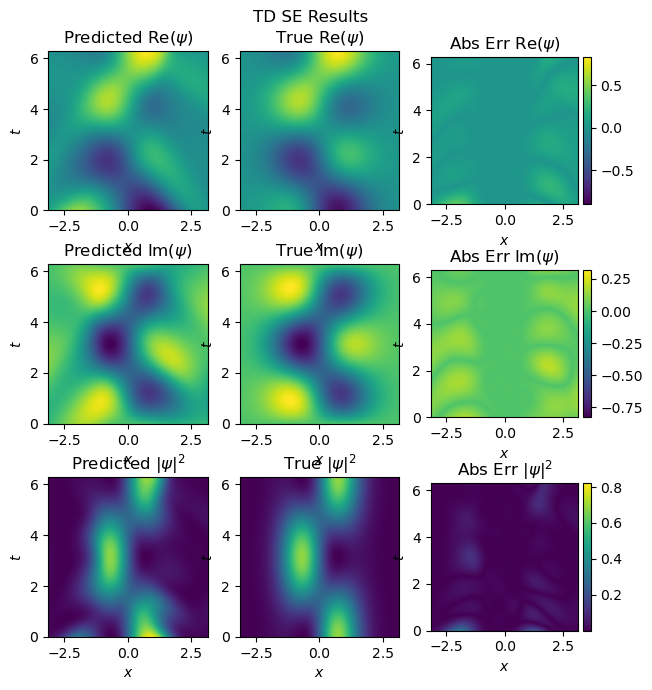

mse: u: 0.005095392866905375, v:0.004248627218404613


In [29]:
L = float(np.pi)
omega = 1
delta_T = 0.01
delta_X = 0.01
    
n_x = np.shape(np.arange(x_dom[0], x_dom[1], delta_X))[0]
n_t = np.shape(np.arange(t_dom[0], t_dom[1], delta_T))[0]

inference(model_pinn, test_x, test_y, n_x, n_t, x_dom, t_dom, omega, 'pinn_reduced')

The PINN model matches the system well, even when trained on reduced data.




#### Training Considerations
##### Architecture
The architecture and associated hyperparameters have significant impact on the performance of the PINN. The learning model architecture can be customized depending on the nature of the domain. For example, CNNs, RNNs and GNNs can be used for spatial, temporal and interacting problems respectively. For the one-dimensional quantum harmonic oscillator workflow, we use a FCN with 3 layers of 20 neurons each. 

Optimizer selection is important for convergence of the learner and to avoid solutions at local minima. It has been shown that a combination of Adam  at early training and L-BFGS for later stages has been effective for solving a variety of PDEs through PINNs. We use the Adam optimizer only given the relatively simple nature of this problem.

---

Exercise: Try running the PINN with ReLU activation function. What are your observations? Why would this activation function not work?

Solution: As we saw in calculating the residual, the choice of activation functions is constrained by the fact that they have to be $(n+1)$-differentiable for $n$-order PDEs. For the one-dimensional quantum harmonic oscillator problem we use $\tanh$ activation functions because they are 3-differentiable.

---

##### Collocation Points
The accuracy of the NN increases with increase in density of collocation points. However, the computational resources required also increases exponentially with the increase in density of points. This can lead to training bottlenecks, especially for high dimensional systems. A trade-off has to be made between the desired accuracy and number of collocation points because training the NN on a large number of points may lead to overfitting and adversely affect generalisability. The distribution of points can also be customised according to the problem domain. Density could be increased around areas of sharp discontinuities to capture more information about the domain. 



---

Exercise: What is the effect of changing collocation points on the training time and accuracy of the Neural Network? You can run it multiple times with different grids of collocation point to observe this.

Solution

Training time and accuracy both increase exponentially with collocation grid size.

<img src="res/fig/pinn_colloc_time.png" alt="Domain" width="300"/>

<img src="res/fig/pinn_colloc_performance.png" alt="Domain" width="300"/>

---


## Higher energy states

We will now check the performance of NNs on systems with higher energy states. For demonstration, the system used is $\psi_{1,3}(x,t)$.  Let's derive the analytical equation first.

---
Exercise: 

a) Derive the first Hermite Polynomial ($H_{3}(y)$) in terms of $x$ for $y=\sqrt{\omega}x$:

Derivation here
$H_{3}(\sqrt{\omega}x) = $

b) Write down the ground state and first excited state energies for QHO:

$E_1 =$,
$E_3=$

c) Use your results from $a$ and $b$ to write down $\psi_{0,1}(x,t)$, and simplify it:

$\psi_{1,3}(x,t) = $


---

Now that we have our analytical solution, let's write some code to compute it for arbitrary values of $x,t,\omega$

In [30]:
def get_analytical_solution_1_3(X,T, omega):
    #Solution:
    phi_0 =(omega / np.pi) ** (1. / 4.) * np.exp(-X * omega * X / 2.0)
    phi_1 = phi_0 *  np.sqrt(omega / 2.) * 2.0 * X
    phi_3 = phi_0 * 1/np.sqrt(48) * (8. * omega**(3./2.) * X**3. - 12. * omega**(1./2.) * X)
    psi = np.sqrt(1. / 2.) * (np.exp(-1j * 3./2. * omega * T) * phi_1 + np.exp(-1j * 7./2. * omega * T) * phi_3)

    return psi

You can explore the system here:

In [31]:
@interact(t=widgets.IntSlider(min=0, max=62, step=1, value=0))
def interactive_viz_colour(t):
    tstr = str(t).zfill(2)
    fname = f"res/plots/waveform/psi_1_3/t_{tstr}.png"
    image = img.imread(fname)
    plt.figure(figsize=(8,6))
    plt.axis('off')
    plt.imshow(image)
    plt.show()

interactive(children=(IntSlider(value=0, description='t', max=62), Output()), _dom_classes=('widget-interact',…

Using a reduced grid with Fully Connected Network, we have

In [32]:
L = float(np.pi)
omega = 1

delta_T = 0.1
delta_X = 0.1
x_dom = [-L/4,L/4]
t_dom = [0, 2*L]

train_x, train_y = get_data_set(x_dom, t_dom, delta_X, delta_T, omega, get_analytical_solution_1_3)

In [33]:
delta_T = 0.01
delta_X = 0.01
x_dom = [-L,L]
t_dom = [0, 2*L]

test_x, test_y = get_data_set(x_dom, t_dom, delta_X, delta_T, omega, get_analytical_solution_1_3)

In [34]:


torch.manual_seed(314)
activation =  nn.Tanh()

model_nn = NN(2,2,32,3,activation)
optimizer = torch.optim.Adam(model_nn.parameters(),lr=1e-3)

n_epochs = 10000

In [35]:
%%time
model_nn, loss_list = train_nn(model_nn, n_epochs, train_x, train_y)
    

Epoch 	 Loss
499 0.034809462660635886
999 0.03075084363695758
1499 0.0295393775833267
1999 0.02767654640213143
2499 0.02513349738631754
2999 0.0191201265706439
3499 0.0160250452954818
3999 0.01369279969429867
4499 0.008533902872647787
4999 0.0043056364979733785
5499 0.0029265635118023744
5999 0.0021766863131497654
6499 0.001639839052664874
6999 0.0012789673588529244
7499 0.001022407290194457
7999 0.0008443914289778758
8499 0.0007270623415503642
8999 0.0007499619234112836
9499 0.0005745309146768787
9999 0.0005206294876606865
CPU times: user 10.9 s, sys: 3.52 s, total: 14.4 s
Wall time: 7.62 s


In [36]:
y_pred = get_model_error(model_nn, test_x, test_y)

Model loss: 
 loss_u=tensor(0.2073) 
 loss_v=tensor(0.3195) 
 loss_dens=tensor(1.0287)


0 finished
1 finished
2 finished


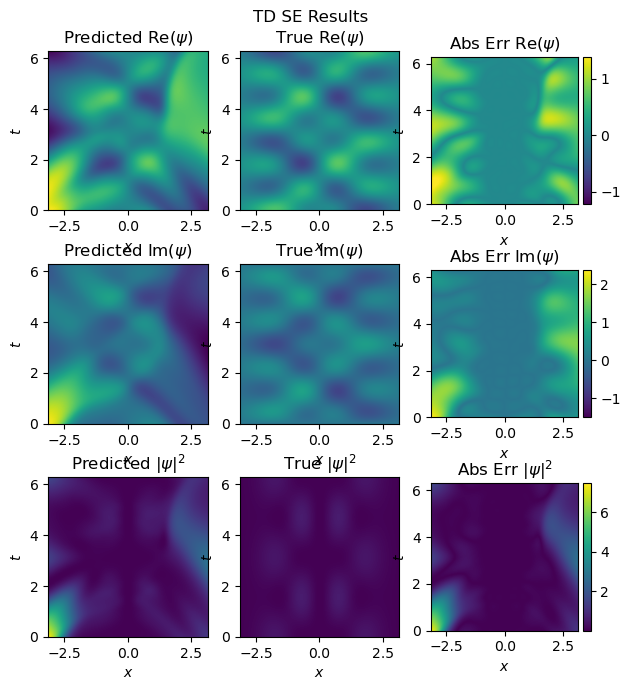

mse: u: 0.20727508699007283, v:0.3194862707860558


In [37]:
L = float(np.pi)
omega = 1
delta_T = 0.01
delta_X = 0.01
    
n_x = np.shape(np.arange(x_dom[0], x_dom[1], delta_X))[0]
n_t = np.shape(np.arange(t_dom[0], t_dom[1], delta_T))[0]

inference(model_nn, test_x, test_y, n_x, n_t, x_dom, t_dom, omega, 'high_nn')

This does not capture any detail beyond the domain, as seen in Abs Err plots. Now for PINNs:

In [38]:
omega = 1
x_dom = [-L,L]
t_dom = [0,2*L]
delta_x = 0.2
delta_t = 0.2
analytical_solution_function = get_analytical_solution_1_3
x_physics, t_physics, f_colloc, b_colloc, ic_colloc, ic = get_physics_colloc_points(x_dom, t_dom, delta_x, delta_t, analytical_solution_function)

In [39]:
debug = False
torch.manual_seed(314)
activation =  nn.Tanh()

n_epochs = 10000
model_pinn = NN(2,2,32,3,activation)



In [40]:
model_pinn, loss_pinn = train_pinn(model_pinn, n_epochs, train_x, train_y, x_physics, t_physics, f_colloc, b_colloc, ic_colloc, ic)

499 0.03480291168571718
999 0.031084838750459233
1499 0.028971769544722088
1999 0.02721349715888194
2499 0.023257275151080507
2999 0.01791301949936464
3499 0.014640661701057437
3999 0.01146101290148794
4499 0.005745520490695615
4999 0.0034858552478852266
5499 0.004602330420850937
5999 0.001939808288830985
6499 0.001522019513295319
6999 0.0012172105171496502
7499 0.0010162861922692413
7999 0.0008534938267632792
8499 0.0007194034281211318
8999 0.000623087135369037
9499 0.0005463454879789895
9999 0.00048368347735618263


In [41]:
y_pred = get_model_error(model_pinn, test_x, test_y)

Model loss: 
 loss_u=tensor(0.0787) 
 loss_v=tensor(0.0430) 
 loss_dens=tensor(0.0118)


In [42]:
L = float(np.pi)
omega = 1
delta_T = 0.01
delta_X = 0.01
    
n_x = np.shape(np.arange(x_dom[0], x_dom[1], delta_X))[0]
n_t = np.shape(np.arange(t_dom[0], t_dom[1], delta_T))[0]
test_x, test_y = get_data_set(x_dom, t_dom, delta_X, delta_T, omega, get_analytical_solution_1_3)

0 finished
1 finished
2 finished


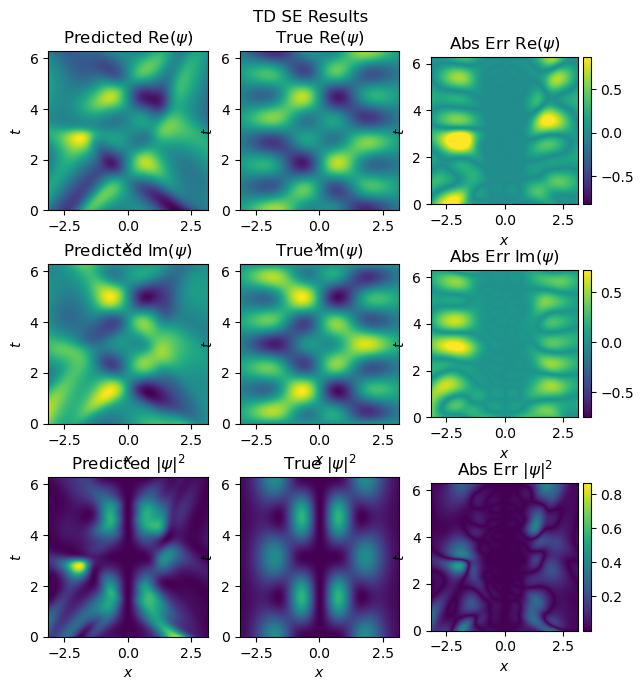

mse: u: 0.07870807831904211, v:0.0429722351310661


In [43]:
inference(model_pinn, test_x, test_y, n_x, n_t, x_dom, t_dom, omega, 'high_pinn')

For higher energy states, it is difficult to capture the details with fully connected layers. PINNs can be extended with Recurrent Neural Networks to tackle this.

## Project Ideas

1. Experiment with different layer types for the higher energy states. One particular layer that might be useful would be gru layer (https://pytorch.org/docs/stable/generated/torch.nn.GRU.html). These layers are used for time series forecasting in Recurrent Neural Networks, which might be helpful for our time dependent system.

2. You can also use causal training loss for the higer energy states. The loss we have been using so far does not take causality into account. For a causal loss function, we divide the domain into consecutive time chunks and use a weighted sum of losses that enforces order in time. You can read more about it here: 

2. Modify the PINNs to work with 2D QHO system
Hint: Since this is a separable system, we can extend it to 2D as follow:
\begin{equation*}
    \phi_n = \phi_n(x)\phi_n(y)
\end{equation*}
\begin{equation*}
    \hat{H} =\hat{H_x}+\hat{H_y}
\end{equation*}

3. Can the neural network generalize over other parameters as well? Add $\omega$ as an input to the neural network and train it to work with a range of $\omega$ values.

4. Implement this network for other systems such as infinite square well.

<!-- Solutions: -->

In [44]:
# debug = False
# torch.manual_seed(123)
# activation =  nn.Tanh()

# n_epochs = 2
# model_pinn_rnn = RNN(2,2,10,3,activation)

# %%time
# model_pinn_rnn, loss_pinn = train_pinn(model_pinn_rnn, n_epochs, train_x, train_y, x_physics, t_physics, f_colloc, b_colloc, ic_colloc, ic)

